In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
from scipy import optimize
from scipy.interpolate import interp1d
from matplotlib import cm

### Определение пробега $\alpha$ частиц при помощи ионизационной камеры

In [39]:
data = pd.read_csv("ion_camera.csv")
data.head()

,P,I
0,0,0.982
1,750,980.000
2,710,977.000
3,662,974.000
4,645,973.000


Text(0.5, 0, 'Давление $P \\ [Торр]$')

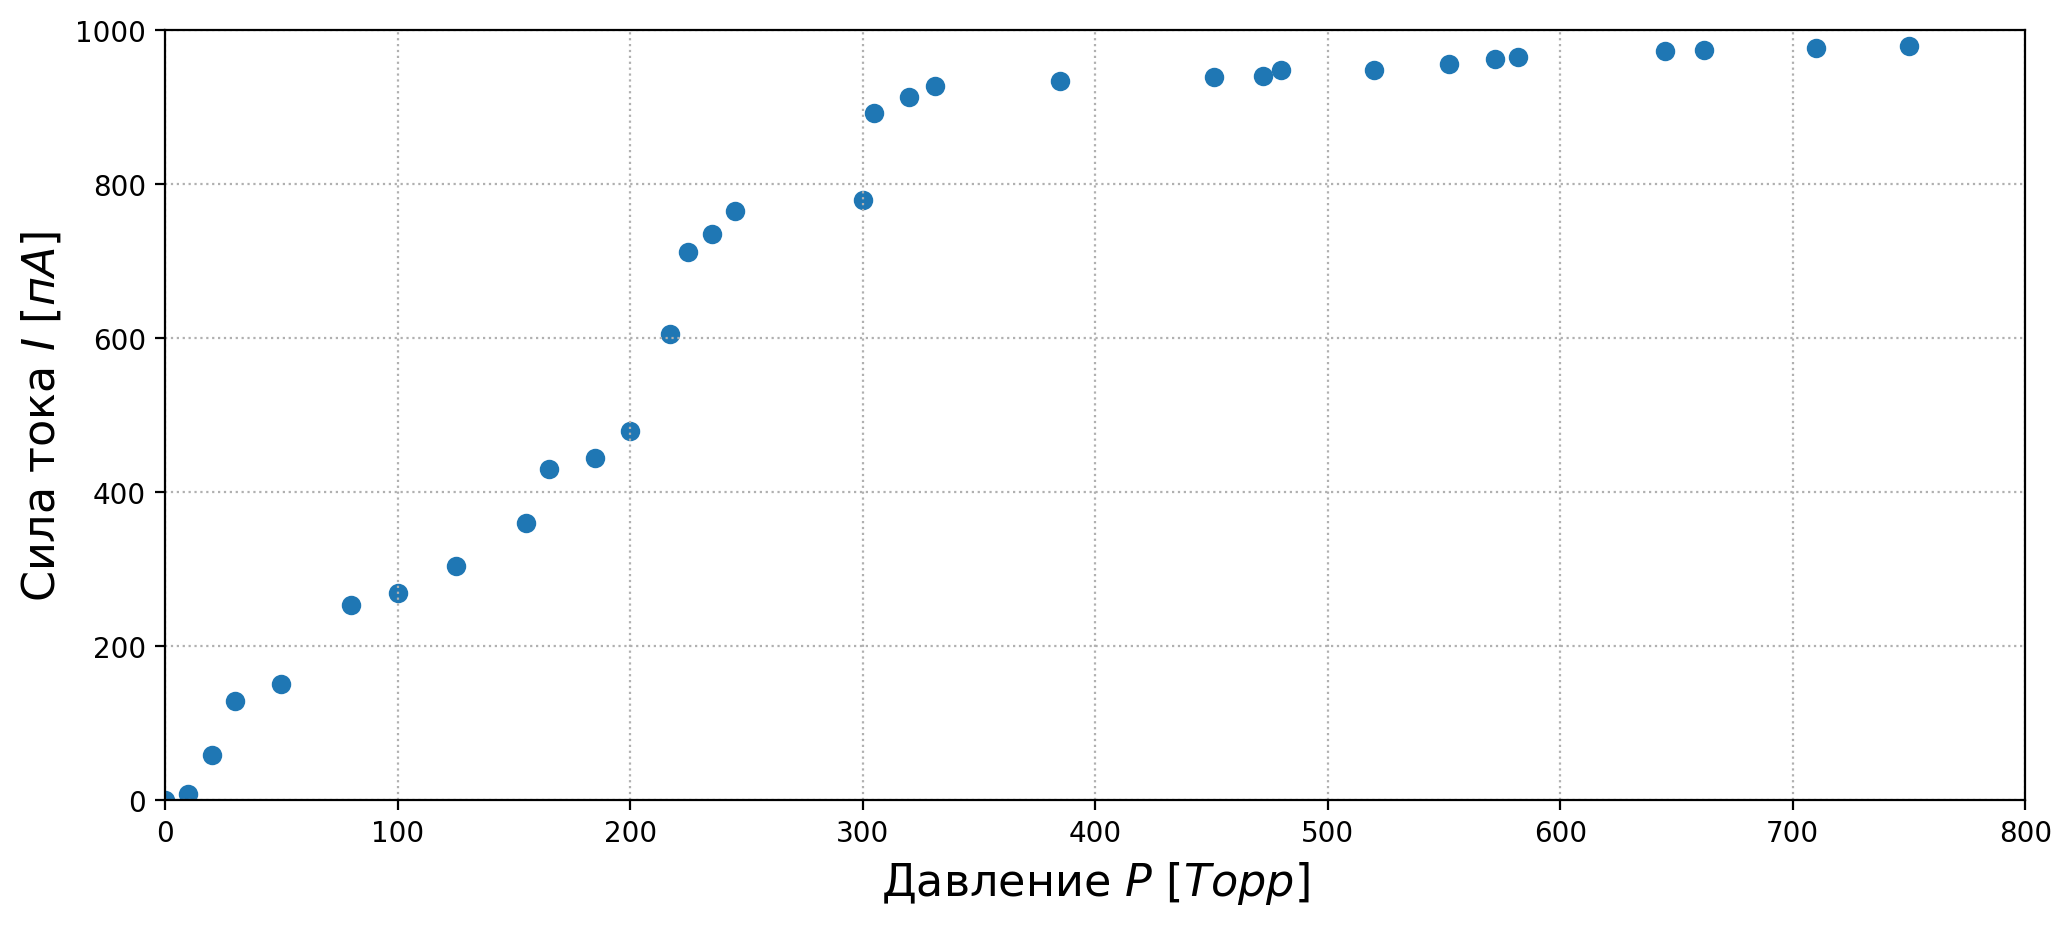

In [40]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(data.P, data.I)
plt.ylim(0, 1000)
plt.grid(ls = ':')
plt.xlim(0, 800)
plt.ylabel("Сила тока $I \ [пА]$", fontsize = 16)
plt.xlabel("Давление $P \ [Торр]$", fontsize = 16)

Интерполируем данные при помощи функции вида:
$$
f(P) = 
 \begin{cases}
   a P, \ \ \ P<P_{0} \\
   c, \ \ \ \ \ P \geq P_{0}
 \end{cases}
$$

In [41]:
def interpolation_func(x: np.ndarray, P0: float, a: float, c: float):
    return np.where(x < P0, a * x, c)

In [42]:
parametrs, cov = optimize.curve_fit(interpolation_func, data.P, data.I,method = 'dogbox', p0 = [340, 2, 900], maxfev = 100000)
print(parametrs)
print(np.diag(cov))
P_interp = np.linspace(0, 1000, 1000)
I_interp = interpolation_func(P_interp, *parametrs)

[340.           2.80910509 958.33333333]
[0.00000000e+00 2.29198629e-03 1.46944971e+02]


(0.0, 800.0)

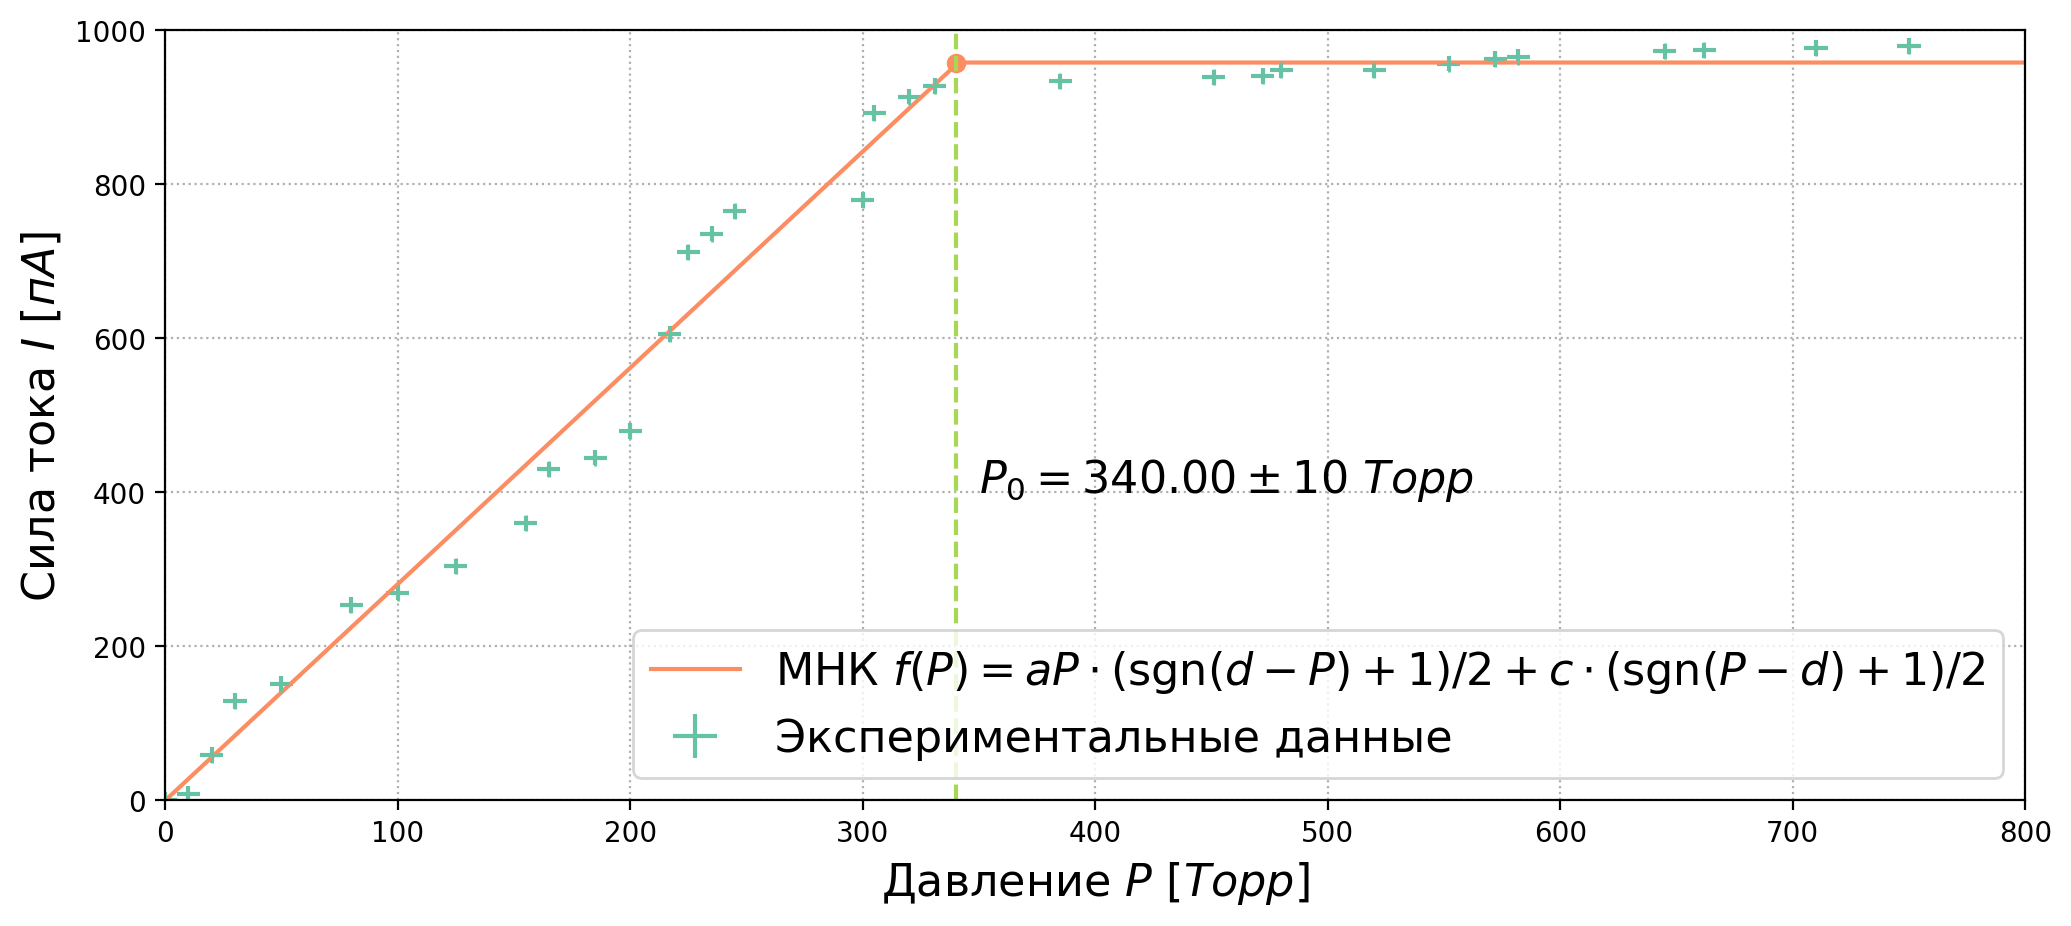

In [43]:
plt.figure(figsize = (12, 5), dpi = 200)

plt.errorbar(data.P, data.I, xerr = [5 for _ in data.P], yerr = [10 for _ in data.I],fmt = '+', color = cm.Set2(0), label = 'Экспериментальные данные')
plt.plot(P_interp, I_interp, color = cm.Set2(1), label = 'МНК $f(P) = a P \cdot (\operatorname{sgn}(d-P) + 1) / 2 + c \cdot(\operatorname{sgn}(P-d) + 1) / 2$')
plt.ylabel("Сила тока $I \ [пА]$", fontsize = 16)
plt.xlabel("Давление $P \ [Торр]$", fontsize = 16)
plt.axvline(parametrs[0], color = cm.Set2(0.5), linestyle = '--')
plt.annotate(text = f"$P_0 = {parametrs[0]:.2f} \pm {10} \ Торр$", xy = (parametrs[0] + 10, 400), fontsize = 16)
plt.scatter([parametrs[0]], [parametrs[2]], color = cm.Set2(1))
plt.ylim(0, 1000)
plt.grid(ls = ':')
plt.legend(fontsize = 16)
plt.xlim(0, 800)

In [44]:
P0 = parametrs[0]
T = 22 + 273
R = (15 + 273) * P0 * (10 - 0.5) / (T * 760 * 2) 
print(f"Длина свободного пробега {R} +- {10 * R / 340}см")

Длина свободного пробега 2.074576271186441 +- 0.061016949152542375см


In [45]:
E = np.power(R / 0.32, 2/3)
print(E, E * 10 / 350)

3.4768526474504866 0.0993386470700139


### Сцинциляционный счетчик


In [46]:
data = pd.read_csv("scintillator.csv")
data.head()
data['dNdt'] = data['N'] / data['t, Time of measurement']
data['Pressure'] = 750 - data['Pressure']

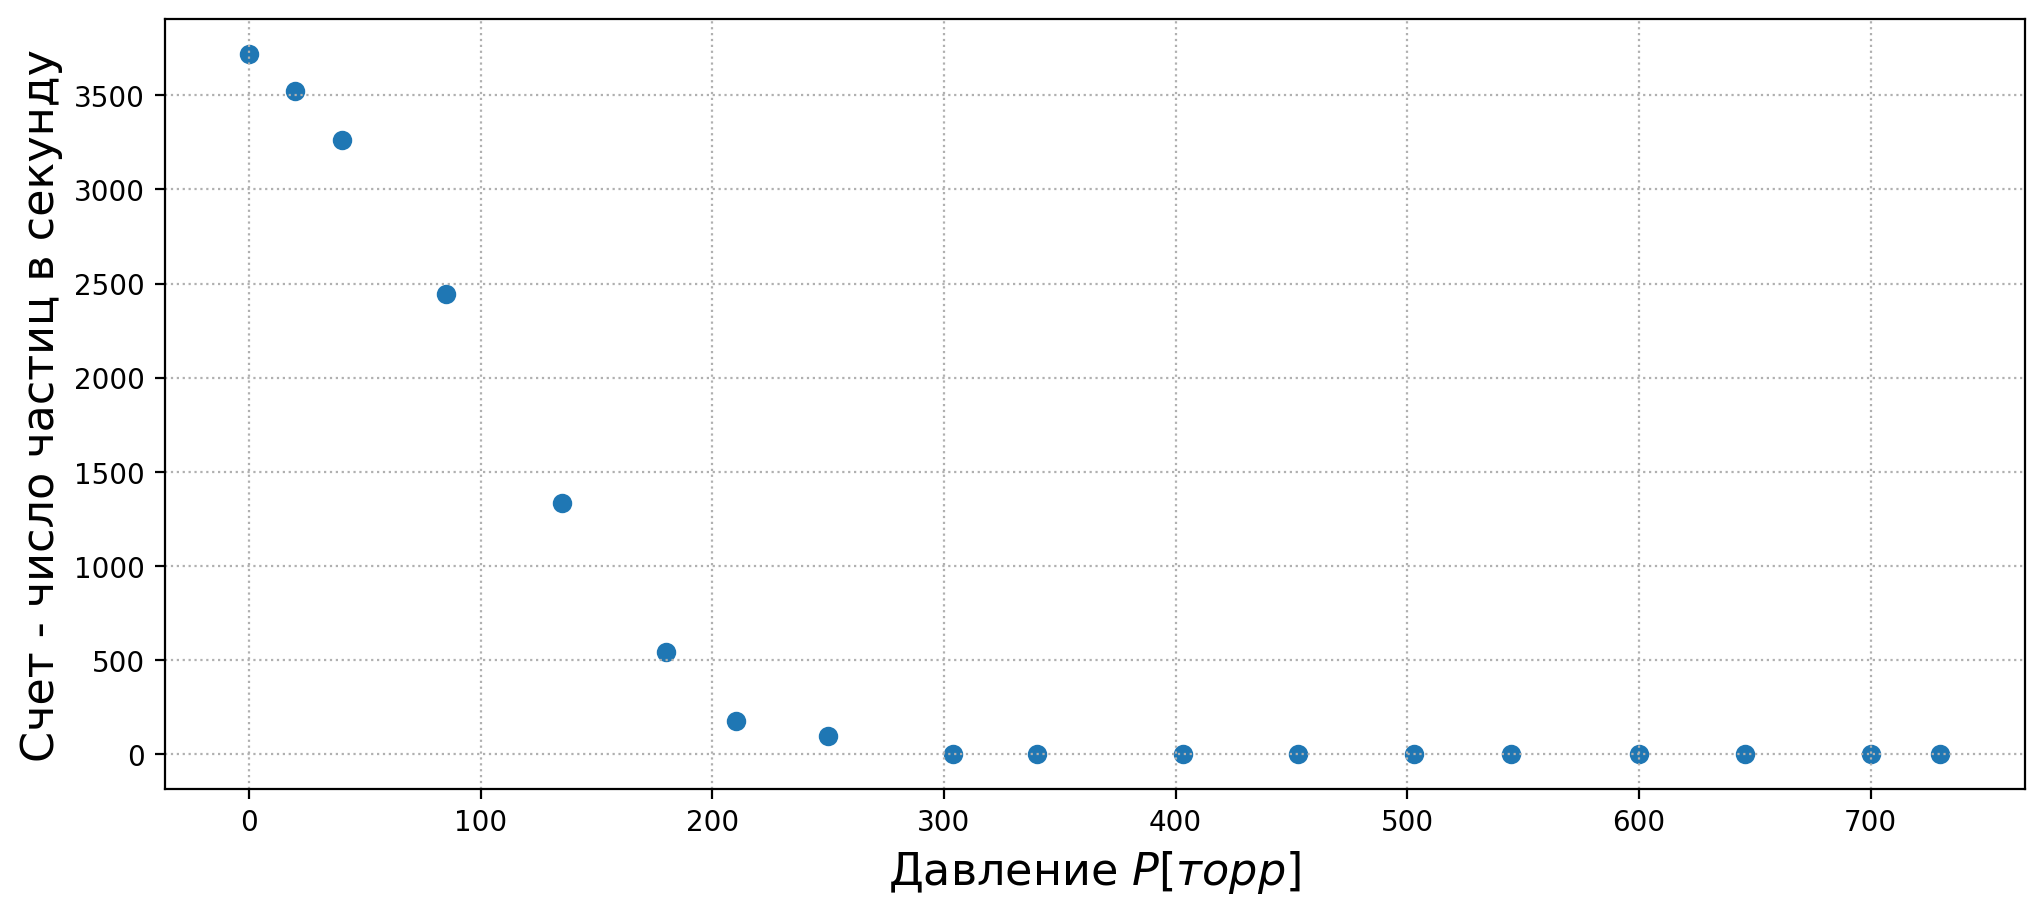

In [47]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(data['Pressure'], data['dNdt'])
plt.xlabel("Давление $P [торр]$", fontsize = 16)
plt.ylabel("Счет - число частиц в секунду", fontsize = 16)
plt.grid(ls = ':')

In [48]:
def fermi_dirac(x, A, bias, x0, c):
    return A / (np.exp((x - x0) / c) + 1) + bias

def fermi_dirac_deriv(x, A, bias, x0, c):
    return (np.exp((x - x0) / c) * A / c) / np.power((np.exp((x - x0) / c) + 1), 2)

param, cov = optimize.curve_fit(fermi_dirac, data['Pressure'], data['dNdt'])
P_interp = np.linspace(0, 1000, 1000)
P_interp_2 = np.linspace(-500, 500, 1000)
P_mean = P_interp[np.argmax(fermi_dirac_deriv(P_interp, *param))]
print(fermi_dirac_deriv(P_mean, *param))
tangent = fermi_dirac(P_mean, *param) + fermi_dirac_deriv(P_mean, *param) * (P_mean - P_interp)
P_extra = P_mean + fermi_dirac(P_mean, *param) / fermi_dirac_deriv(P_mean, *param) 
print("Средний", P_mean)
print("Экстраполированный", P_extra)
print(param)

24.47869769025882
Средний 105.10510510510511
Экстраполированный 186.02701200189782
[-3967.56298186  3958.50882157   105.35575266   -40.52018084]


/home/vladimir/BOTAY!/Labs/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


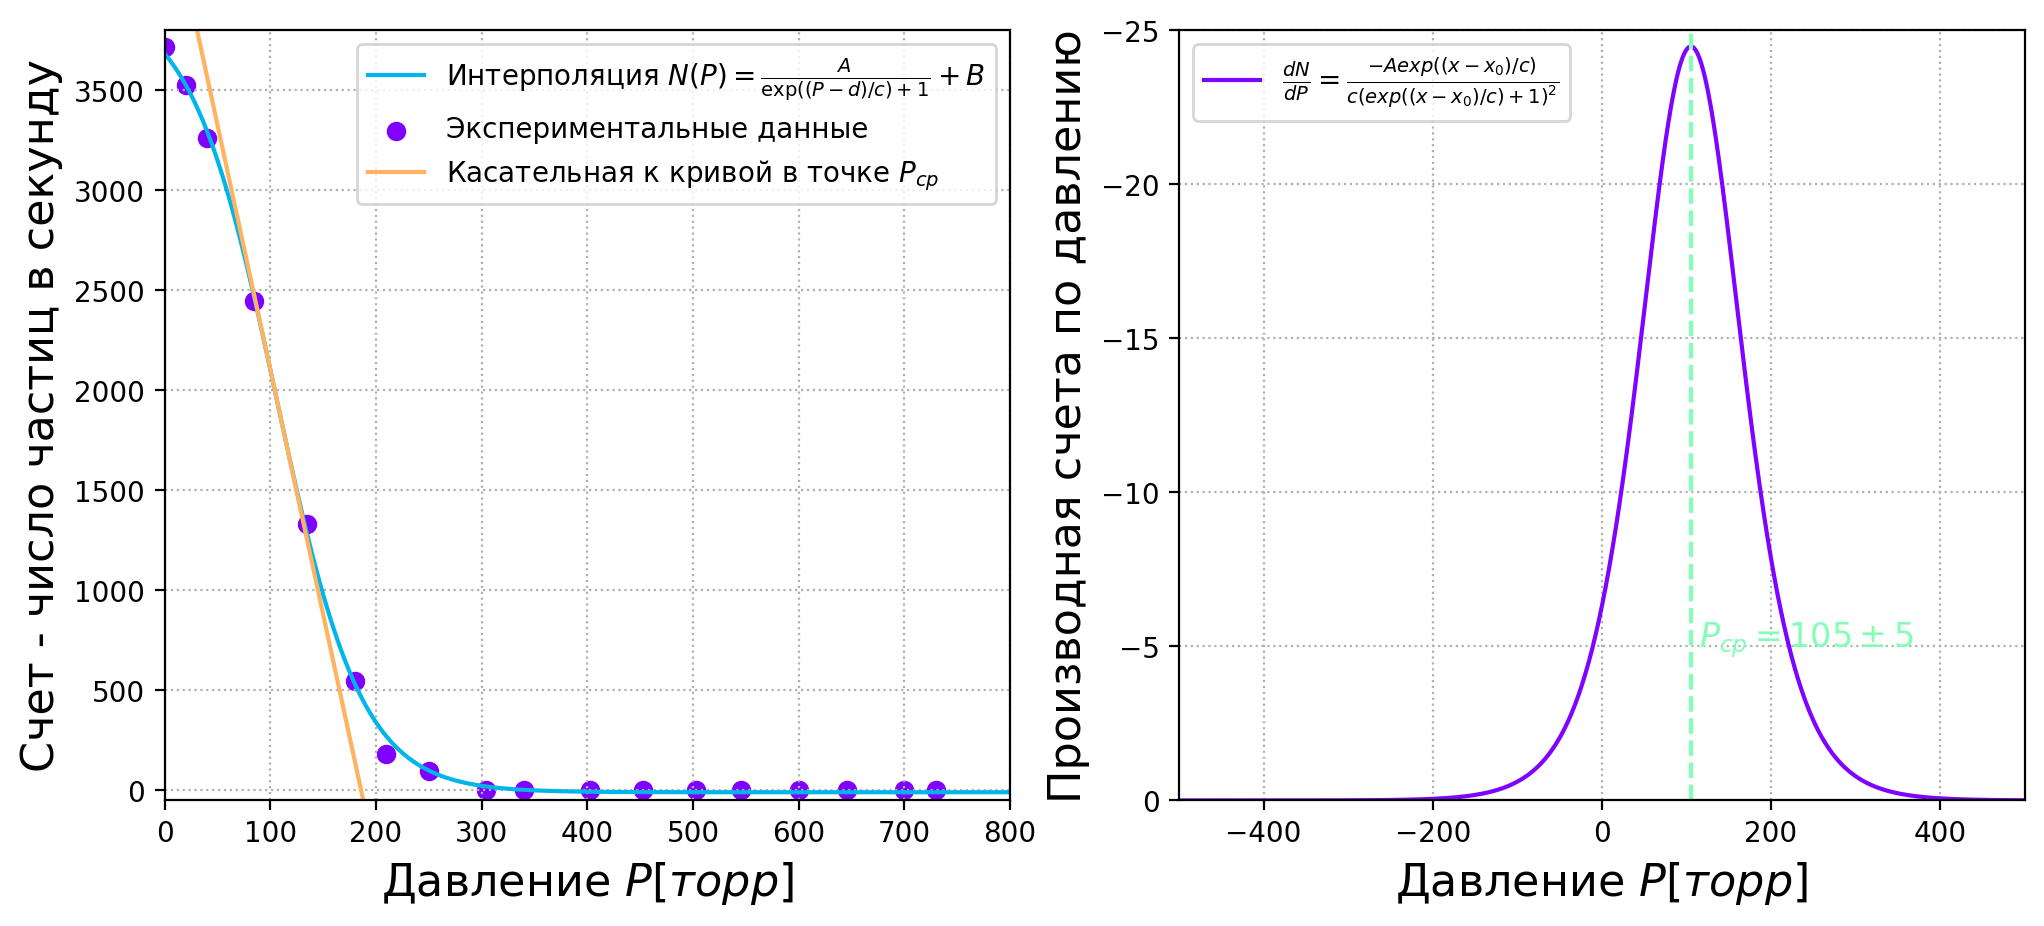

In [49]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi = 200)
colorscheme = cm.rainbow
ax[1].plot(P_interp_2, -fermi_dirac_deriv(P_interp_2, *param), label = r'$ \frac{dN}{dP} = \frac{-Aexp((x-x_0) / c)}{c (exp((x-x_0) / c) + 1)^{2}}$', color = colorscheme(1))
ax[0].plot(P_interp, fermi_dirac(P_interp, *param), label = r'Интерполяция $N(P) = \frac{A}{\operatorname{exp}((P - d) / c) + 1} + B$', color = colorscheme(1/4))
ax[0].scatter(data['Pressure'], data['dNdt'], label = 'Экспериментальные данные', color = colorscheme(0))
ax[0].plot(P_interp, tangent, color = colorscheme(0.75), label = r'Касательная к кривой в точке $P_{ср}$')
ax[1].axvline(P_mean, color = colorscheme(0.5), linestyle = '--')
ax[1].annotate("$P_{ср} = " + f"{P_mean:.0f} \pm {0.047 * P_mean:.0f}$", xy = (P_mean + 10, -5), color = colorscheme(0.5), fontsize = 12)

ax[0].set_xlim(0, 800)
ax[0].set_ylim(-50, 3800)
ax[1].set_xlim(-500, 500)
ax[1].set_ylim(0, -25)
ax[0].set_xlabel("Давление $P [торр]$", fontsize = 16)
ax[1].set_xlabel("Давление $P [торр]$", fontsize = 16)
ax[0].set_ylabel("Счет - число частиц в секунду", fontsize = 16)
ax[1].set_ylabel("Производная счета по давлению", fontsize = 16)
for a in ax:
    a.legend(fontsize = 10)
    a.grid(ls = ':')

In [50]:
R_mean = 288 * P_mean * 9 / (T * 760)
R_extra = 288 * P_extra * 9 / (T * 760)
print(R_mean)
print(R_extra)

1.215131277575524
2.150678033492057


In [51]:
E_mean = np.power(R_mean / 0.32, 2/3)
E_extra = np.power(R_extra / 0.32, 2/3)
print(E_mean)
print(E_extra)

2.4339714569470186
3.561368781019172


In [53]:
x =  R_extra / np.power(5.12, 1.5) 
print(x)

0.1856395290077127
